In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. *damage_labeling.csv* 제작하기
* Raw data 목록으로부터 모델이 데이터셋을 로드할 때 읽을 .csv 및 .json 파일을 생성한다.

In [ ]:
# make index list
damage_json_list = []
for filename in os.listdir("/content/drive/MyDrive/Co-deep/data/Dataset/1.원천데이터/damage"):
  damage_json_list.append(filename)

In [ ]:
N = 2000
total_anns = []
Scratched = []
Breakage = []
Separated = []
Crushed = []
ran_var = [0 for i in range(N)]


PATH = "/content/drive/MyDrive/Co-deep/data/Dataset/2.라벨링데이터/damage"
for filename in os.listdir("/content/drive/MyDrive/Co-deep/data/Dataset/2.라벨링데이터/damage"):
    path = PATH + str('/') + filename
    with open(str(path), "r") as json_file:
      json_load = json.load(json_file)
      # total_anns
      total_anns.append(len(json_load['annotations']))
      # 4개
      dm_list = []
      for i in json_load['annotations']:
        dm_list.append(i['damage'])
      
      Scratched.append(sum(np.array(dm_list) == "Scratched"))
      Breakage.append(sum(np.array(dm_list) == "Breakage"))
      Separated.append(sum(np.array(dm_list) == "Separated"))
      Crushed.append(sum(np.array(dm_list) == "Crushed"))

In [ ]:
# for spliting train / val / test dataset
tvt_split=[]
for i in range(N):
  if i % 7 == 5:
    tvt_split.append('val')
  elif i % 7 == 6:
    tvt_split.append('test')
  else:
    tvt_split.append('train')

In [ ]:
Counter(tvt_split)

Counter({'train': 1430, 'val': 285, 'test': 285})

In [ ]:
damage_labeling = pd.concat([pd.DataFrame(damage_json_list), pd.DataFrame(Scratched), pd.DataFrame(Breakage), pd.DataFrame(Separated), 
                             pd.DataFrame(Crushed), pd.DataFrame(total_anns), pd.DataFrame(ran_var), pd.DataFrame(tvt_split)], axis = 1)
damage_labeling.columns = ['index', 'Scratched', 'Breakage', 'Separated', 'Crushed', 'total_anns', 'ran_var', 'dataset']
damage_labeling

,index,Scratched,Breakage,Separated,Crushed,total_anns,ran_var,dataset
0,0507432_as-3314287.jpg,2,2,1,1,6,0,train
1,0507420_sc-1040741.jpg,3,0,0,0,3,0,train
2,0507445_as-0046949.jpg,2,0,1,0,3,0,train
3,0507468_as-7373159.jpg,4,0,0,0,4,0,train
4,0507469_sc-116500.jpg,4,2,3,0,9,0,train
...,...,...,...,...,...,...,...,...
1995,0507478_as-3147515.jpg,1,1,1,1,4,0,train
1996,0507416_sc-104825.jpg,0,0,1,0,1,0,train
1997,0507477_sc-196898.jpg,1,0,0,1,2,0,train
1998,0507426_sc-181541.jpg,1,0,1,0,2,0,train


In [ ]:
# damage_labeling.to_csv('/content/drive/MyDrive/Co-deep/code/damage_labeling.csv')

### 2. Revise annotation files to *Coco format*

기존 Annotation 파일 형식을 데이터를 load할 수 있는 형태로 바꾸어주는 단계이다.

In [2]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 5.9 MB/s 
     |████████████████████████████████| 376 kB 42.8 MB/s 
     |████████████████████████████████| 58 kB 8.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=325f229bd665d6503593439a1187cbae51e10460350b8cc44a7e7ba72e86253d
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=063865bf879d2b6dfefa34a83ec2d2b4285e1694d0d47b4dcda251029ebbec50
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Co-deep/')

!python code/src/Utils.py --make_cocoformat 1 --task damage

# annotation format 
# {
# 'info': {'name': 'external', 'date_created': '03/08/2022'},
# 'images': [{'id': 1, 'width': 800, 'height':600, 'file_name': '*.jpg'}, {'id': 2, ... }, ... ]
# 'annotations': [{'id': 1, 'image_id': 1, 'category_id': _, 'segmentation': [[xxx.xxx, ... ]] , ...  }, {'id': 1, ...}, ... ] # 여기의 id는 ann id
# }

### 3. Visualizing Original Image and Annotation

학습시키기 이전, 모델에 입력되는 원본 사진들과 annotation이 잘 맞는지 확인하는 작업을 거쳤다.

3-1. Load original image

In [ ]:
import os
import cv2
from pycocotools.coco import COCO
from google.colab.patches import cv2_imshow

os.chdir('/content/drive/MyDrive/Co-deep/code')
img_base_path = '/content/drive/MyDrive/Co-deep/data/Dataset/1.원천데이터/damage'
train_dir = f"../data/datainfo/damage_Scratched_train.json"
coco = COCO(train_dir)

index = 45
image_id = coco.getImgIds([index])
image_infos = coco.loadImgs(image_id)[0]


image = cv2.imread(os.path.join(img_base_path, image_infos['file_name']))
cv2_imshow(image)

3-2. Plot annotation polygon on original image

In [ ]:
import numpy as np

ann_ids = coco.getAnnIds(imgIds=image_infos['id']) # image id로 부터 대응되는 annotation id 가져오기
anns = coco.loadAnns(ann_ids)  # ann id는 고유값을 가지도록 첫번째 이미지의 annotation부터 누적

print(ann_ids)
print(anns)

img_with_ann = image.copy()

# ann['sementation'] 읽어와 원본 이미지에 plot
for ann in anns:
  if ann['damage'] == 'Separated':
  # if ann['damage'] == 'Scratched':
    print(ann['id'], ann['segmentation'])
    poly_list = []
    for point_float in ann["segmentation"][0]:
      point_list = []
      x, y = str(point_float).split('.')
      point_list.append(int(x))
      point_list.append(int(y))
      poly_list.append(point_list)
    poly = np.array(poly_list)
    img_with_ann = cv2.polylines(img_with_ann, [poly], True, (0,255,0), thickness=2)


cv2_imshow(img_with_ann)

[2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614]
[{'id': 2607, 'image_id': 866, 'category_id': 0, 'segmentation': [[284.186, 309.186, 306.206, 281.246, 285.274, 277.287, 264.287, 245.262, 278.216, 284.186]], 'area': 2645.5, 'bbox': [245, 186, 64, 101], 'damage': 'Scratched', 'part': None, 'year': 2016, 'color': 'White', 'level': None, 'repair': ['Front bumper:repair,coating,sheet_metal']}, {'id': 2608, 'image_id': 866, 'category_id': 0, 'segmentation': [[202.337, 211.351, 209.365, 182.361, 202.337]], 'area': 441.0, 'bbox': [182, 337, 29, 28], 'damage': 'Scratched', 'part': None, 'year': 2016, 'color': 'White', 'level': None, 'repair': ['Front bumper:repair,coating,sheet_metal']}, {'id': 2609, 'image_id': 866, 'category_id': 0, 'segmentation': [[21.42, 29.48, 36.64, 16.58, 4.85, 0.59, 21.42]], 'area': 553.5, 'bbox': [0, 42, 36, 43], 'damage': 'Scratched', 'part': None, 'year': 2016, 'color': 'White', 'level': None, 'repair': ['Front bumper:repair,coating,sheet_metal']}, {'id': 2610, 'im

### 4. Train & Validation

##### 5-1. BCE Loss 실험
- `criterion = torch.nn.BCELossWithLogits()`

In [ ]:
### 실험 2-1
# damage
# BCELoss
# new model
# th - 0.4

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.7443448305130005
masks shape:  torch.Size([16, 

In [ ]:
### 실험 2-2
# damage
# BCELoss
# new model
# th - 0.6

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.6561798453330994
masks shape:  torch.Size([16, 

In [ ]:
### 실험 2-3
# damage
# BCELoss
# new model
# th - 0.3

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.7122417688369751
masks shape:  torch.Size([16, 

In [ ]:
### 실험 2-4
# damage
# BCELoss
# new model
# th - 0.25

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.7368509769439697
masks shape:  torch.Size([16, 

##### 5-2. Focal Loss 실험 (threshold = 0.475)

In [ ]:
### 실험 1-1
# damage
# FocalLoss
# new model
# th - 0.35

!python main.py --train y --task damage --label all  

# 전부 target으로 예측해버림 

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.0
masks shape:  torch.Size([16, 1, 256, 256])
o

In [ ]:
### 실험 1-2
# damage
# FocalLoss
# new model
# th - 0.75

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.0
masks shape:  torch.Size([16, 1, 256, 256])
o

In [ ]:
### 실험 1-3
# damage
# FocalLoss
# new model
# th - 0.5

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.0
masks shape:  torch.Size([16, 1, 256, 256])
o

In [ ]:
### 실험 1-4
# damage
# FocalLoss
# new model
# th - 0.4
# 보면 0.35는 target으로만 하고 0.5, 0.75는 background로만 하니까..!

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.0
masks shape:  torch.Size([16, 1, 256, 256])
o

In [ ]:
### 실험 1-5
# damage
# FocalLoss
# new model
# th - 0.45
# 보면 0.35, 0.4는 target으로만 하고 0.5, 0.75는 background로만 하니까..!

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.0
masks shape:  torch.Size([16, 1, 256, 256])
o

In [ ]:
### 실험 1-6
# damage
# FocalLoss
# new model
# th - 0.475
# 보면 0.35, 0.4, 0.45는 target으로만 하고 0.5, 0.75는 background로만 하니까..!

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.0
masks shape:  torch.Size([16, 1, 256, 256])
o

In [ ]:
### 실험 1-7
# damage
# FocalLoss
# new model
# th - 0.48
# 보면 0.35, 0.4, 0.45는 target으로만 하고 0.5, 0.75는 background로만 하니까..!

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
masks shape:  torch.Size([16, 1, 256, 256])
outputs shape:  torch.Size([16, 1, 256, 256])
step 0 | loss 0.0
masks shape:  torch.Size([16, 1, 256, 256])
o

In [ ]:
### 실험 3-1 ######################################################### 별
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
# th - 0.475
# FocalLoss alpha = 0.25, gamma=2

!python main.py --train y --task damage --label all  
# 문제점 : 개선이 되지 않고 수치가 아예 동일하다.
# 사실상 이게 가능한 문제인지 모르겠다. 

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
/content/drive/MyDrive/Co-deep/code/src/Train.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider con

In [ ]:
### 실험 3-2
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
# th - 0.5
# FocalLoss alpha = 0.25, gamma=2

!python main.py --train y --task damage --label all  
# 문제점 : 개선이 되지 않고 수치가 아예 동일하다.
# 사실상 이게 가능한 문제인지 모르겠다. 

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
/content/drive/MyDrive/Co-deep/code/src/Train.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider con

In [ ]:
# alpha = 0.2, 0.25, 0.75
# gamma = 1,2,3

In [ ]:
### 실험 3-3
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
# th - 0.475
# FocalLoss alpha = 0.2, gamma=1

!python main.py --train y --task damage --label all 

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
/content/drive/MyDrive/Co-deep/code/src/Train.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider con

In [ ]:
### 실험 3-4
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
#### th - 0.475 : 고정 : 그냥 이게 최고인 것이야ㅑ
# FocalLoss alpha = 0.2, gamma=2

!python main.py --train y --task damage --label all 

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
/content/drive/MyDrive/Co-deep/code/src/Train.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider con

In [ ]:
### 실험 3-4
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
#### th - 0.475 : 고정 : 그냥 이게 최고인 것이야ㅑ
# FocalLoss alpha = 0.2, gamma=3

!python main.py --train y --task damage --label all

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [      0   47785]]
('0506321_sc-1028706.jpg', '0506393_as-0049821.jpg', '0506336_sc-193542.jpg', '0506409_sc-111021.jpg', '0506419_sc-201032.jpg', '0506434_sc-200938.jpg', '0506424_as-7008961.jpg', '0506443_as-0078573.jpg', '0506480_as-0004338.jpg', '0506508_sc-205780.jpg', '0506505_sc-205780.jpg', '0506516_sc-1007334.jpg', '0506451_sc-155167.jpg', '0506489_as-3317669.jpg', '0506482_as-2592949.jpg', '0506501_sc-205780.jpg')
hist bin [[    0 57958]
 [    0  7578]]
hist bin [[    0 63313]
 [    0  2223]]
hist bin [[    0 48819]
 [    0 16717]]
hist bin [[    0 61294]
 [    0  4242]]
hist bin [[    0 60139]
 [    0  5397]]
hist bin [[    0 59813]
 [    0  5723]]
hist bin [[    0 63139]
 [    0  2397]]
hist bin [[    0 65002]
 [    0   534]]
hist bin [[    0 64137]
 [    0  1399]]
hist bin [[    0 55301]
 [    0 10235]]
hist bin [[    0 65480]
 [    0    56]]
hist bin [[    0 55714]
 [    0  9822]]
hist bin [[    0 65536]
 [    0     0]]
hist bin [[    

In [ ]:
### 실험 3-5
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
#### th - 0.475 : 고정 : 그냥 이게 최고인 것이야ㅑ
# FocalLoss alpha = 0.25, gamma=1

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
/content/drive/MyDrive/Co-deep/code/src/Train.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider con

In [ ]:
### 실험 3-5
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
#### th - 0.475 : 고정 : 그냥 이게 최고인 것이야ㅑ
# FocalLoss alpha = 0.25, gamma=2

!python main.py --train y --task damage --label all

gpu device num
0
Training of  Scratched
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
name: external
date_created: 03/08/2022
None
--- start-training ---
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded train data: 1279
Loaded val data: 285
epoch: 1
/content/drive/MyDrive/Co-deep/code/src/Train.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider con

#### 5-3. Train (w. Dice Loss)

5-1, 5-2는 trial and error로, 최종 학습은 Dice Loss로 학습하였다.

In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 3.9 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
     |████████████████████████████████| 376 kB 30.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=91508029c613711828046c4e6116dca374b311cbe6affa52d8f50385713b7308
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=529f39ed6d16a8a30763bde36bf96cf422ca7e9da819ff616bf80bfe5398f593
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels


최종 결과

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Co-deep/code")
!python main.py --train y --task damage --label all  

gpu device num
0
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: socar
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: socar
date_created: 03/08/2022
None
--- start-training ---
Loaded train data: 1264
Loaded val data: 285
epoch: 1
step 0 | loss 0.8518046140670776
step 10 | loss 0.8135462999343872
step 20 | loss 0.8304505944252014
step 30 | loss 0.761221706867218
step 40 | loss 0.7964877486228943
step 50 | loss 0.7655830383300781
step 60 | loss 0.774547815322876
step 70 | loss 0.6867213249206543
number of classes: 1
Start validation # epoch 1 # step 78
[[12147958.  4929602.]
 [  485060.  1115140.]]
Validation #1 #17 Average Loss: 0.7475, mIoU: 0.4312, background IoU : 0.6917, target IoU : 0.1708, precision : 0.1845, recall : 0.6969, F1_score : 0.2917, balanced_accuracy : 1.0513
avrg_loss, mIoU, cls_IoU : tensor(0.7475, device='cuda:0') 0.43123547529025397 [0.69169395 0.170777

### cf. Defining Customized function
pycocotools 의 `annToMask()`가 현재 우리의 데이터셋 형식으로는 적용이 잘 안 되어서 유사한 함수를 정의하였다.

(Utils.py의 `customizedAnnToMask()`)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def customizedAnnToMask(ann, height, width):  # 'segmentation': [[ [x.y], [x.y], ...  , [x.y] ]]

  coco_seg = ann['segmentation'][0]
  contours = []

  # [x.y] -> [x,y]

  for point in coco_seg:
    point = str(point)
    x, y = point.split('.')
    revised_point = [int(x), int(y)]
    contours.append(revised_point)
  
  ann_mask = np.zeros((height, width))
  contours = np.asarray(contours, dtype=np.int32)
  cv2.fillPoly( ann_mask, pts=[contours], color=(1, 1, 1))
  
  return ann_mask  

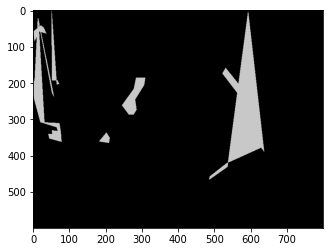

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mask = np.zeros((image_infos['height'], image_infos['width']))

for ann in anns:
  if ann['category_id'] == 0:
    mask = np.maximum(customizedAnnToMask(ann, image_infos['height'], image_infos['width'], ann['category_id']), mask)
    masks = masks.astype(np.int32)
  
mask = mask * 100 # pixel 값이 1이면 육안으로 0과 1 구분이 안돼서
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)


### cf. Trial for loading pretrained model and fine tuning

weight의 shape이 맞지 않아 pretrained model을 load하는데 실패하였다.

In [ ]:
["../data/weight/"+n for n in ["[DAMAGE][Scratch_0]Unet.pt","[DAMAGE][Seperated_1]Unet.pt","[DAMAGE][Crushed_2]Unet.pt","[DAMAGE][Breakage_3]Unet.pt"]]

['../data/weight/[DAMAGE][Scratch_0]Unet.pt',
 '../data/weight/[DAMAGE][Seperated_1]Unet.pt',
 '../data/weight/[DAMAGE][Crushed_2]Unet.pt',
 '../data/weight/[DAMAGE][Breakage_3]Unet.pt']

In [ ]:
!python main.py --eval y --task damage --label all

gpu device num
0
start_validation damage Scratched
conv1.weight
###########
bn1.running_mean
###########
bn1.running_var
###########
bn1.weight
###########
bn1.bias
###########
layer1.0.conv1.weight
###########
layer1.0.bn1.running_mean
###########
layer1.0.bn1.running_var
###########
layer1.0.bn1.weight
###########
layer1.0.bn1.bias
###########
layer1.0.conv2.weight
###########
layer1.0.bn2.running_mean
###########
layer1.0.bn2.running_var
###########
layer1.0.bn2.weight
###########
layer1.0.bn2.bias
###########
layer1.1.conv1.weight
###########
layer1.1.bn1.running_mean
###########
layer1.1.bn1.running_var
###########
layer1.1.bn1.weight
###########
layer1.1.bn1.bias
###########
layer1.1.conv2.weight
###########
layer1.1.bn2.running_mean
###########
layer1.1.bn2.running_var
###########
layer1.1.bn2.weight
###########
layer1.1.bn2.bias
###########
layer1.2.conv1.weight
###########
layer1.2.bn1.running_mean
###########
layer1.2.bn1.running_var
###########
layer1.2.bn1.weight
##########

In [ ]:
!python main.py --eval y --task damage --label all

gpu device num
0
start_validation damage Scratched
conv1.weight
###########
model.encoder.conv1.weight
bn1.running_mean
###########
model.encoder.bn1.running_mean
bn1.running_var
###########
model.encoder.bn1.running_var
bn1.weight
###########
model.encoder.bn1.weight
bn1.bias
###########
model.encoder.bn1.bias
layer1.0.conv1.weight
###########
model.encoder.layer1.0.conv1.weight
layer1.0.bn1.running_mean
###########
model.encoder.layer1.0.bn1.running_mean
layer1.0.bn1.running_var
###########
model.encoder.layer1.0.bn1.running_var
layer1.0.bn1.weight
###########
model.encoder.layer1.0.bn1.weight
layer1.0.bn1.bias
###########
model.encoder.layer1.0.bn1.bias
layer1.0.conv2.weight
###########
model.encoder.layer1.0.conv2.weight
layer1.0.bn2.running_mean
###########
model.encoder.layer1.0.bn2.running_mean
layer1.0.bn2.running_var
###########
model.encoder.layer1.0.bn2.running_var
layer1.0.bn2.weight
###########
model.encoder.layer1.0.bn2.weight
layer1.0.bn2.bias
###########
model.encoder.l

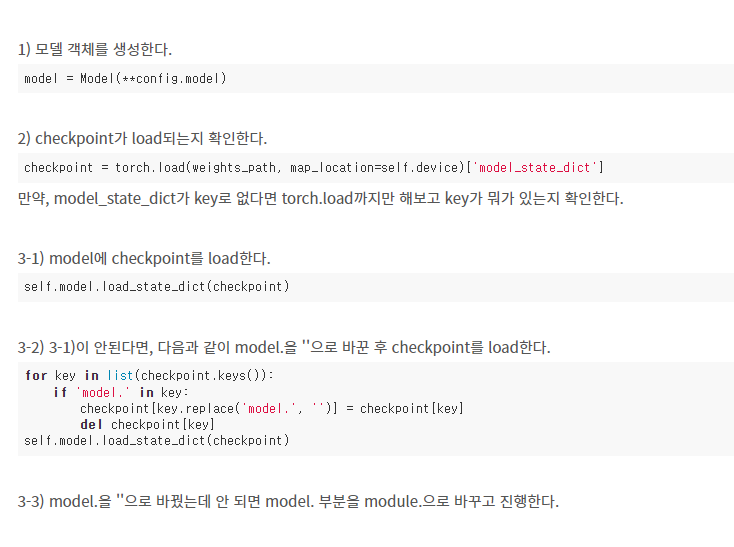

In [ ]:
a = ["model.encoder.conv1.weight", "model.encoder.bn1.weight", "model.encoder.bn1.bias", "model.encoder.bn1.running_mean", "model.encoder.bn1.running_var", "model.encoder.layer1.0.conv1.weight", "model.encoder.layer1.0.bn1.weight", "model.encoder.layer1.0.bn1.bias", "model.encoder.layer1.0.bn1.running_mean", "model.encoder.layer1.0.bn1.running_var", "model.encoder.layer1.0.conv2.weight", "model.encoder.layer1.0.bn2.weight", "model.encoder.layer1.0.bn2.bias", "model.encoder.layer1.0.bn2.running_mean", "model.encoder.layer1.0.bn2.running_var", "model.encoder.layer1.1.conv1.weight", "model.encoder.layer1.1.bn1.weight", "model.encoder.layer1.1.bn1.bias", "model.encoder.layer1.1.bn1.running_mean", "model.encoder.layer1.1.bn1.running_var", "model.encoder.layer1.1.conv2.weight", "model.encoder.layer1.1.bn2.weight", "model.encoder.layer1.1.bn2.bias", "model.encoder.layer1.1.bn2.running_mean", "model.encoder.layer1.1.bn2.running_var", "model.encoder.layer1.2.conv1.weight", "model.encoder.layer1.2.bn1.weight", "model.encoder.layer1.2.bn1.bias", "model.encoder.layer1.2.bn1.running_mean", "model.encoder.layer1.2.bn1.running_var", "model.encoder.layer1.2.conv2.weight", "model.encoder.layer1.2.bn2.weight", "model.encoder.layer1.2.bn2.bias", "model.encoder.layer1.2.bn2.running_mean", "model.encoder.layer1.2.bn2.running_var", "model.encoder.layer2.0.conv1.weight", "model.encoder.layer2.0.bn1.weight", "model.encoder.layer2.0.bn1.bias", "model.encoder.layer2.0.bn1.running_mean", "model.encoder.layer2.0.bn1.running_var", "model.encoder.layer2.0.conv2.weight", "model.encoder.layer2.0.bn2.weight", "model.encoder.layer2.0.bn2.bias", "model.encoder.layer2.0.bn2.running_mean", "model.encoder.layer2.0.bn2.running_var", "model.encoder.layer2.0.downsample.0.weight", "model.encoder.layer2.0.downsample.1.weight", "model.encoder.layer2.0.downsample.1.bias", "model.encoder.layer2.0.downsample.1.running_mean", "model.encoder.layer2.0.downsample.1.running_var", "model.encoder.layer2.1.conv1.weight", "model.encoder.layer2.1.bn1.weight", "model.encoder.layer2.1.bn1.bias", "model.encoder.layer2.1.bn1.running_mean", "model.encoder.layer2.1.bn1.running_var", "model.encoder.layer2.1.conv2.weight", "model.encoder.layer2.1.bn2.weight", "model.encoder.layer2.1.bn2.bias", "model.encoder.layer2.1.bn2.running_mean", "model.encoder.layer2.1.bn2.running_var", "model.encoder.layer2.2.conv1.weight", "model.encoder.layer2.2.bn1.weight", "model.encoder.layer2.2.bn1.bias", "model.encoder.layer2.2.bn1.running_mean", "model.encoder.layer2.2.bn1.running_var", "model.encoder.layer2.2.conv2.weight", "model.encoder.layer2.2.bn2.weight", "model.encoder.layer2.2.bn2.bias", "model.encoder.layer2.2.bn2.running_mean", "model.encoder.layer2.2.bn2.running_var", "model.encoder.layer2.3.conv1.weight", "model.encoder.layer2.3.bn1.weight", "model.encoder.layer2.3.bn1.bias", "model.encoder.layer2.3.bn1.running_mean", "model.encoder.layer2.3.bn1.running_var", "model.encoder.layer2.3.conv2.weight", "model.encoder.layer2.3.bn2.weight", "model.encoder.layer2.3.bn2.bias", "model.encoder.layer2.3.bn2.running_mean", "model.encoder.layer2.3.bn2.running_var", "model.encoder.layer3.0.conv1.weight", "model.encoder.layer3.0.bn1.weight", "model.encoder.layer3.0.bn1.bias", "model.encoder.layer3.0.bn1.running_mean", "model.encoder.layer3.0.bn1.running_var", "model.encoder.layer3.0.conv2.weight", "model.encoder.layer3.0.bn2.weight", "model.encoder.layer3.0.bn2.bias", "model.encoder.layer3.0.bn2.running_mean", "model.encoder.layer3.0.bn2.running_var", "model.encoder.layer3.0.downsample.0.weight", "model.encoder.layer3.0.downsample.1.weight", "model.encoder.layer3.0.downsample.1.bias", "model.encoder.layer3.0.downsample.1.running_mean", "model.encoder.layer3.0.downsample.1.running_var", "model.encoder.layer3.1.conv1.weight", "model.encoder.layer3.1.bn1.weight", "model.encoder.layer3.1.bn1.bias", "model.encoder.layer3.1.bn1.running_mean", "model.encoder.layer3.1.bn1.running_var", "model.encoder.layer3.1.conv2.weight", "model.encoder.layer3.1.bn2.weight", "model.encoder.layer3.1.bn2.bias", "model.encoder.layer3.1.bn2.running_mean", "model.encoder.layer3.1.bn2.running_var", "model.encoder.layer3.2.conv1.weight", "model.encoder.layer3.2.bn1.weight", "model.encoder.layer3.2.bn1.bias", "model.encoder.layer3.2.bn1.running_mean", "model.encoder.layer3.2.bn1.running_var", "model.encoder.layer3.2.conv2.weight", "model.encoder.layer3.2.bn2.weight", "model.encoder.layer3.2.bn2.bias", "model.encoder.layer3.2.bn2.running_mean", "model.encoder.layer3.2.bn2.running_var", "model.encoder.layer3.3.conv1.weight", "model.encoder.layer3.3.bn1.weight", "model.encoder.layer3.3.bn1.bias", "model.encoder.layer3.3.bn1.running_mean", "model.encoder.layer3.3.bn1.running_var", "model.encoder.layer3.3.conv2.weight", "model.encoder.layer3.3.bn2.weight", "model.encoder.layer3.3.bn2.bias", "model.encoder.layer3.3.bn2.running_mean", "model.encoder.layer3.3.bn2.running_var", "model.encoder.layer3.4.conv1.weight", "model.encoder.layer3.4.bn1.weight", "model.encoder.layer3.4.bn1.bias", "model.encoder.layer3.4.bn1.running_mean", "model.encoder.layer3.4.bn1.running_var", "model.encoder.layer3.4.conv2.weight", "model.encoder.layer3.4.bn2.weight", "model.encoder.layer3.4.bn2.bias", "model.encoder.layer3.4.bn2.running_mean", "model.encoder.layer3.4.bn2.running_var", "model.encoder.layer3.5.conv1.weight", "model.encoder.layer3.5.bn1.weight", "model.encoder.layer3.5.bn1.bias", "model.encoder.layer3.5.bn1.running_mean", "model.encoder.layer3.5.bn1.running_var", "model.encoder.layer3.5.conv2.weight", "model.encoder.layer3.5.bn2.weight", "model.encoder.layer3.5.bn2.bias", "model.encoder.layer3.5.bn2.running_mean", "model.encoder.layer3.5.bn2.running_var", "model.encoder.layer4.0.conv1.weight", "model.encoder.layer4.0.bn1.weight", "model.encoder.layer4.0.bn1.bias", "model.encoder.layer4.0.bn1.running_mean", "model.encoder.layer4.0.bn1.running_var", "model.encoder.layer4.0.conv2.weight", "model.encoder.layer4.0.bn2.weight", "model.encoder.layer4.0.bn2.bias", "model.encoder.layer4.0.bn2.running_mean", "model.encoder.layer4.0.bn2.running_var", "model.encoder.layer4.0.downsample.0.weight", "model.encoder.layer4.0.downsample.1.weight", "model.encoder.layer4.0.downsample.1.bias", "model.encoder.layer4.0.downsample.1.running_mean", "model.encoder.layer4.0.downsample.1.running_var", "model.encoder.layer4.1.conv1.weight", "model.encoder.layer4.1.bn1.weight", "model.encoder.layer4.1.bn1.bias", "model.encoder.layer4.1.bn1.running_mean", "model.encoder.layer4.1.bn1.running_var", "model.encoder.layer4.1.conv2.weight", "model.encoder.layer4.1.bn2.weight", "model.encoder.layer4.1.bn2.bias", "model.encoder.layer4.1.bn2.running_mean", "model.encoder.layer4.1.bn2.running_var", "model.encoder.layer4.2.conv1.weight", "model.encoder.layer4.2.bn1.weight", "model.encoder.layer4.2.bn1.bias", "model.encoder.layer4.2.bn1.running_mean", "model.encoder.layer4.2.bn1.running_var", "model.encoder.layer4.2.conv2.weight", "model.encoder.layer4.2.bn2.weight", "model.encoder.layer4.2.bn2.bias", "model.encoder.layer4.2.bn2.running_mean", "model.encoder.layer4.2.bn2.running_var", "model.decoder.blocks.0.conv1.0.weight", "model.decoder.blocks.0.conv1.1.weight", "model.decoder.blocks.0.conv1.1.bias", "model.decoder.blocks.0.conv1.1.running_mean", "model.decoder.blocks.0.conv1.1.running_var", "model.decoder.blocks.0.conv2.0.weight", "model.decoder.blocks.0.conv2.1.weight", "model.decoder.blocks.0.conv2.1.bias", "model.decoder.blocks.0.conv2.1.running_mean", "model.decoder.blocks.0.conv2.1.running_var", "model.decoder.blocks.1.conv1.0.weight", "model.decoder.blocks.1.conv1.1.weight", "model.decoder.blocks.1.conv1.1.bias", "model.decoder.blocks.1.conv1.1.running_mean", "model.decoder.blocks.1.conv1.1.running_var", "model.decoder.blocks.1.conv2.0.weight", "model.decoder.blocks.1.conv2.1.weight", "model.decoder.blocks.1.conv2.1.bias", "model.decoder.blocks.1.conv2.1.running_mean", "model.decoder.blocks.1.conv2.1.running_var", "model.decoder.blocks.2.conv1.0.weight", "model.decoder.blocks.2.conv1.1.weight", "model.decoder.blocks.2.conv1.1.bias", "model.decoder.blocks.2.conv1.1.running_mean", "model.decoder.blocks.2.conv1.1.running_var", "model.decoder.blocks.2.conv2.0.weight", "model.decoder.blocks.2.conv2.1.weight", "model.decoder.blocks.2.conv2.1.bias", "model.decoder.blocks.2.conv2.1.running_mean", "model.decoder.blocks.2.conv2.1.running_var", "model.decoder.blocks.3.conv1.0.weight", "model.decoder.blocks.3.conv1.1.weight", "model.decoder.blocks.3.conv1.1.bias", "model.decoder.blocks.3.conv1.1.running_mean", "model.decoder.blocks.3.conv1.1.running_var", "model.decoder.blocks.3.conv2.0.weight", "model.decoder.blocks.3.conv2.1.weight", "model.decoder.blocks.3.conv2.1.bias", "model.decoder.blocks.3.conv2.1.running_mean", "model.decoder.blocks.3.conv2.1.running_var", "model.decoder.blocks.4.conv1.0.weight", "model.decoder.blocks.4.conv1.1.weight", "model.decoder.blocks.4.conv1.1.bias", "model.decoder.blocks.4.conv1.1.running_mean", "model.decoder.blocks.4.conv1.1.running_var", "model.decoder.blocks.4.conv2.0.weight", "model.decoder.blocks.4.conv2.1.weight", "model.decoder.blocks.4.conv2.1.bias", "model.decoder.blocks.4.conv2.1.running_mean", "model.decoder.blocks.4.conv2.1.running_var", "model.segmentation_head.0.weight", "model.segmentation_head.0.bias"]
a

['model.encoder.conv1.weight',
 'model.encoder.bn1.weight',
 'model.encoder.bn1.bias',
 'model.encoder.bn1.running_mean',
 'model.encoder.bn1.running_var',
 'model.encoder.layer1.0.conv1.weight',
 'model.encoder.layer1.0.bn1.weight',
 'model.encoder.layer1.0.bn1.bias',
 'model.encoder.layer1.0.bn1.running_mean',
 'model.encoder.layer1.0.bn1.running_var',
 'model.encoder.layer1.0.conv2.weight',
 'model.encoder.layer1.0.bn2.weight',
 'model.encoder.layer1.0.bn2.bias',
 'model.encoder.layer1.0.bn2.running_mean',
 'model.encoder.layer1.0.bn2.running_var',
 'model.encoder.layer1.1.conv1.weight',
 'model.encoder.layer1.1.bn1.weight',
 'model.encoder.layer1.1.bn1.bias',
 'model.encoder.layer1.1.bn1.running_mean',
 'model.encoder.layer1.1.bn1.running_var',
 'model.encoder.layer1.1.conv2.weight',
 'model.encoder.layer1.1.bn2.weight',
 'model.encoder.layer1.1.bn2.bias',
 'model.encoder.layer1.1.bn2.running_mean',
 'model.encoder.layer1.1.bn2.running_var',
 'model.encoder.layer1.2.conv1.weight',


In [ ]:
b = ["conv1.weight", "bn1.running_mean", "bn1.running_var", "bn1.weight", "bn1.bias", "layer1.0.conv1.weight", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.conv2.weight", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.1.conv1.weight", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.conv2.weight", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.2.conv1.weight", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.conv2.weight", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer2.0.conv1.weight", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.conv2.weight", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.1.conv1.weight", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.conv2.weight", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.2.conv1.weight", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.conv2.weight", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.3.conv1.weight", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.conv2.weight", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer3.0.conv1.weight", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.conv2.weight", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.1.conv1.weight", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.conv2.weight", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.2.conv1.weight", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.conv2.weight", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.3.conv1.weight", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.conv2.weight", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.4.conv1.weight", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.conv2.weight", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.5.conv1.weight", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.conv2.weight", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer4.0.conv1.weight", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.conv2.weight", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.1.conv1.weight", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.conv2.weight", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.2.conv1.weight", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.conv2.weight", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "fc.weight", "fc.bias"]
b

['conv1.weight',
 'bn1.running_mean',
 'bn1.running_var',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.running_mean',
 'layer1.0.bn1.running_var',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.running_mean',
 'layer1.0.bn2.running_var',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.running_mean',
 'layer1.1.bn1.running_var',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.running_mean',
 'layer1.1.bn2.running_var',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer1.2.conv1.weight',
 'layer1.2.bn1.running_mean',
 'layer1.2.bn1.running_var',
 'layer1.2.bn1.weight',
 'layer1.2.bn1.bias',
 'layer1.2.conv2.weight',
 'layer1.2.bn2.running_mean',
 'layer1.2.bn2.running_var',
 'layer1.2.bn2.weight',
 'layer1.2.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.running_mean',
 'layer2.0.bn1.running_var',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias